In [1]:
from feature_utils.parallel import BufferedSOAPFeatures, get_features_in_parallel, get_optimal_radial_basis_hypers_parallel
from loader.loader import load_data
from copy import deepcopy
import numpy as np
from sklearn.linear_model import RidgeCV
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import get_optimal_radial_basis_hypers
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_id
from skcosmo.model_selection import atom_groups_by_frame
from sklearn.linear_model import LinearRegression, Ridge
from copy import deepcopy
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import time
from sklearn.compose import TransformedTargetRegressor
from skcosmo.preprocessing import StandardFlexibleScaler
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.svm import LinearSVR

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import PairwiseKernel

In [2]:
from skcosmo.preprocessing import StandardFlexibleScaler

In [4]:
wrapped_model = TransformedTargetRegressor(regressor=Ridge(), transformer=StandardFlexibleScaler())

In [5]:
import sklearn

In [6]:
sklearn.__version__

'1.0.2'

In [17]:
wrapped_model.get_params()

{'check_inverse': True,
 'func': None,
 'inverse_func': None,
 'regressor__alpha': 1.0,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__max_iter': None,
 'regressor__normalize': False,
 'regressor__random_state': None,
 'regressor__solver': 'auto',
 'regressor__tol': 0.001,
 'regressor': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 'transformer__atol': 1e-12,
 'transformer__column_wise': False,
 'transformer__copy': False,
 'transformer__rtol': 0,
 'transformer__with_mean': True,
 'transformer__with_std': True,
 'transformer': StandardFlexibleScaler(atol=1e-12, column_wise=False, copy=False, rtol=0,
                        with_mean=True, with_std=True)}

In [2]:
train_structures, test_structures, train_properties, test_properties = load_data("./make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "./make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=7, random_subsample_test=200)

In [10]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=8,
              max_angular=8,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1,
                    scale=5.0,
                    exponent=3.1
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )
start_time = time.time()
get_features_in_parallel(train_structures,SOAP,hypers,n_cores=8)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7550456523895264 seconds ---


In [5]:
calc_object = BufferedSOAPFeatures(train_structures,hypers,optimize=False,n_cores=8)
start_time = time.time()
X = calc_object.get_features({})
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.665013313293457 seconds ---


In [6]:
X.shape

(134692, 8640)

In [7]:
start_time = time.time()
get_optimal_radial_basis_hypers_parallel(hypers,train_structures)
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.396571397781372 seconds ---


In [3]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=8,
              max_angular=8,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1,
                    scale=2.0,
                    exponent=3
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )

nested_param = dict(rate=1,
                    scale=3.0,
                    exponent=6
                        )

"""space = [Real(10**-5, 10**2, "log-uniform", name='alpha'),
        Real(0.05,1.5, "uniform", name="gaussian_sigma_constant"),
        Real(2.,4.5, "uniform", name="interaction_cutoff")]"""

space = [Real(10**-3, 10**1, "log-uniform", name='regressor__C'),
        #Real(1.,3.5, "uniform", name="scale"),
        Real(3.5,8.0, "uniform", name="interaction_cutoff"),
        Real(0.01,0.5, "uniform", name="gaussian_sigma_constant"),
        #Real(1.,5., "uniform", name="exponent"),
        #Real(0.5,3., "uniform", name="rate")
        ]

reg = TransformedTargetRegressor(regressor=LinearSVR(loss="squared_epsilon_insensitive"), transformer=StandardFlexibleScaler(),check_inverse=False)
y = train_properties
atom_groups = atom_groups_by_frame(train_structures)
Feature_gen = BufferedSOAPFeatures(train_structures, hypers,optimize=False,n_cores=-1)




@use_named_args(space)
def soap_objective(**params):
    update_dict = {}
    
    new_params = params.copy()
    #nested_dict_param = deepcopy(Feature_gen.calculator_params)
    #nested_dict_param = nested_dict_param["cutoff_function_parameters"]
    
    for key, value in new_params.items():
        if key in Feature_gen.calculator_params:
            #hypers[key] = value
            update_dict[key] = params.pop(key, None)
        """if key in nested_param:
            nested_dict_param[key] = params.pop(key, None)
            #print("I update my {} to {}".format(key,value))
        
        update_dict["cutoff_function_parameters"] = nested_dict_param"""
            
            
    #print(update_dict)
    start_time = time.time()
    reg.set_params(**params)
    
    
    X = Feature_gen.get_features(update_dict)
    print("--- feature_gen time %s seconds ---" % (time.time() - start_time))
    #print(X.shape)
    
    #print(Feature_gen.hypers["max_angular"])
    start_time = time.time()
    splits = list(GroupKFold(n_splits=3).split(X,y,groups=atom_groups))
    
    start_time = time.time()
    score = -np.mean(cross_val_score(reg, X, y, cv=splits, n_jobs=1,
                                    scoring="neg_mean_squared_error"))
    
    print("--- cross_val time %s seconds ---" % (time.time() - start_time))
        
    return score

In [24]:
reg.get_params()

{'check_inverse': False,
 'func': None,
 'inverse_func': None,
 'regressor__C': 1.0,
 'regressor__dual': True,
 'regressor__epsilon': 0.0,
 'regressor__fit_intercept': True,
 'regressor__intercept_scaling': 1.0,
 'regressor__loss': 'epsilon_insensitive',
 'regressor__max_iter': 1000,
 'regressor__random_state': None,
 'regressor__tol': 0.0001,
 'regressor__verbose': 0,
 'regressor': LinearSVR(),
 'transformer__atol': 1e-12,
 'transformer__column_wise': False,
 'transformer__copy': False,
 'transformer__rtol': 0,
 'transformer__with_mean': True,
 'transformer__with_std': True,
 'transformer': StandardFlexibleScaler()}

In [14]:
class MyFlex(StandardFlexibleScaler):
    def _validate_data(
        self,
        X="no_validation",
        y="no_validation",
        reset=True,
        validate_separately=False,
        **check_params,
    ):
        """Validate input data and set or check the `n_features_in_` attribute.
        Parameters
        ----------
        X : {array-like, sparse matrix, dataframe} of shape \
                (n_samples, n_features), default='no validation'
            The input samples.
            If `'no_validation'`, no validation is performed on `X`. This is
            useful for meta-estimator which can delegate input validation to
            their underlying estimator(s). In that case `y` must be passed and
            the only accepted `check_params` are `multi_output` and
            `y_numeric`.
        y : array-like of shape (n_samples,), default='no_validation'
            The targets.
            - If `None`, `check_array` is called on `X`. If the estimator's
              requires_y tag is True, then an error will be raised.
            - If `'no_validation'`, `check_array` is called on `X` and the
              estimator's requires_y tag is ignored. This is a default
              placeholder and is never meant to be explicitly set. In that case
              `X` must be passed.
            - Otherwise, only `y` with `_check_y` or both `X` and `y` are
              checked with either `check_array` or `check_X_y` depending on
              `validate_separately`.
        reset : bool, default=True
            Whether to reset the `n_features_in_` attribute.
            If False, the input will be checked for consistency with data
            provided when reset was last True.
            .. note::
               It is recommended to call reset=True in `fit` and in the first
               call to `partial_fit`. All other methods that validate `X`
               should set `reset=False`.
        validate_separately : False or tuple of dicts, default=False
            Only used if y is not None.
            If False, call validate_X_y(). Else, it must be a tuple of kwargs
            to be used for calling check_array() on X and y respectively.
        **check_params : kwargs
            Parameters passed to :func:`sklearn.utils.check_array` or
            :func:`sklearn.utils.check_X_y`. Ignored if validate_separately
            is not False.
        Returns
        -------
        out : {ndarray, sparse matrix} or tuple of these
            The validated input. A tuple is returned if both `X` and `y` are
            validated.
        """
        self._check_feature_names(X, reset=reset)

        if y is None and self._get_tags()["requires_y"]:
            raise ValueError(
                f"This {self.__class__.__name__} estimator "
                "requires y to be passed, but the target y is None."
            )

        no_val_X = isinstance(X, str) and X == "no_validation"
        no_val_y = y is None or isinstance(y, str) and y == "no_validation"

        if no_val_X and no_val_y:
            raise ValueError("Validation should be done on X, y or both.")
        elif not no_val_X and no_val_y:
            X = check_array(X, **check_params)
            out = X
        elif no_val_X and not no_val_y:
            y = _check_y(y, **check_params)
            out = y
        else:
            if validate_separately:
                # We need this because some estimators validate X and y
                # separately, and in general, separately calling check_array()
                # on X and y isn't equivalent to just calling check_X_y()
                # :(
                check_X_params, check_y_params = validate_separately
                X = check_array(X, **check_X_params)
                y = check_array(y, **check_y_params)
            else:
                X, y = check_X_y(X, y, **check_params)
            out = X, y

        if not no_val_X and check_params.get("ensure_2d", True):
            self._check_n_features(X, reset=reset)

        return out

In [4]:
## patch_sklearn()
import time
start_time = time.time()
res_gp = gp_minimize(soap_objective, space, n_calls=10, random_state=0, n_jobs=1)
print("--- 10 steps took %s seconds ---" % (time.time() - start_time))

--- feature_gen time 5.957897901535034 seconds ---
--- cross_val time 26.52699875831604 seconds ---
--- feature_gen time 4.739871025085449 seconds ---
--- cross_val time 105.88008952140808 seconds ---
--- feature_gen time 3.4844846725463867 seconds ---
--- cross_val time 15.451254844665527 seconds ---
--- feature_gen time 5.721749305725098 seconds ---
--- cross_val time 19.410589456558228 seconds ---
--- feature_gen time 5.756065607070923 seconds ---
--- cross_val time 17.039902925491333 seconds ---
--- feature_gen time 4.013485431671143 seconds ---
--- cross_val time 32.404414892196655 seconds ---
--- feature_gen time 6.085181713104248 seconds ---
--- cross_val time 15.952741384506226 seconds ---
--- feature_gen time 4.390804767608643 seconds ---
--- cross_val time 76.05135440826416 seconds ---
--- feature_gen time 4.580217599868774 seconds ---
--- cross_val time 46.89388561248779 seconds ---
--- feature_gen time 3.6919443607330322 seconds ---
--- cross_val time 56.11977291107178 seco

In [ ]:
--- feature_gen time 1.4659466743469238 seconds ---
--- cross_val time 3.2741000652313232 seconds ---
--- feature_gen time 1.0049035549163818 seconds ---
--- cross_val time 1.3749923706054688 seconds ---
--- feature_gen time 0.6205904483795166 seconds ---
--- cross_val time 4.839658498764038 seconds ---
--- feature_gen time 1.286834955215454 seconds ---
--- cross_val time 4.872981071472168 seconds ---
--- feature_gen time 1.240980863571167 seconds ---
--- cross_val time 4.9696455001831055 seconds ---
--- feature_gen time 0.7608432769775391 seconds ---
--- cross_val time 2.616834878921509 seconds ---
--- feature_gen time 1.2775135040283203 seconds ---
--- cross_val time 4.769025802612305 seconds ---
--- feature_gen time 0.8656597137451172 seconds ---
--- cross_val time 1.5502421855926514 seconds ---
--- feature_gen time 0.9591543674468994 seconds ---
--- cross_val time 1.8793525695800781 seconds ---
--- feature_gen time 0.6200380325317383 seconds ---
--- cross_val time 1.605391025543213 seconds ---
--- 10 steps took 42.09602952003479 seconds ---



In [20]:
!conda update scikit-learn


PackageNotInstalledError: Package is not installed in prefix.
  prefix: /ssd/scratch/kellner/miniconda3
  package name: scikit-learn




#time fit n_-1, n_cores=1 = 400 seconds
#time fit n_-1, n_cores=8 = 342 seconds
#time fit n_-1, n_cores=8, njobs=-1 =338 seconds

--- feature_gen time 55.961002826690674 seconds ---
--- cross_val time 272.33899450302124 seconds ---
--- feature_gen time 39.429200172424316 seconds ---
--- cross_val time 271.1294071674347 seconds ---
--- feature_gen time 54.26414370536804 seconds ---
--- cross_val time 272.70380902290344 seconds ---
--- feature_gen time 40.761064291000366 seconds ---
--- cross_val time 269.0713834762573 seconds ---
--- feature_gen time 37.434038400650024 seconds ---
--- cross_val time 272.76407980918884 seconds ---
--- feature_gen time 43.45965504646301 seconds ---


In [11]:
res_gp.x_iters

[[0.5530405118212187,
  3.1885314971620353,
  7.360755279302406,
  0.42515335200422155],
 [0.9738892550769331,
  2.2687634145853997,
  4.838905729450126,
  0.037789358885547165],
 [0.0015179251497629848,
  2.4553302346427,
  7.154759279489721,
  0.24518881446377816],
 [0.013876449797222516,
  3.1721575270747557,
  5.018282721877708,
  0.3276042173050867],
 [0.008829422902952801,
  3.414310317906093,
  4.131578511856903,
  0.43634275659563393],
 [0.06149847721451149,
  3.1018215039592887,
  5.842148657980422,
  0.3426509697582906],
 [5.821853031748781,
  2.6640395841502142,
  5.918179532520549,
  0.38172165591795515],
 [7.034947447310314e-05,
  2.4472008386933153,
  4.33849554497042,
  0.37108990679318954],
 [0.0005400112846473881,
  1.7704363468109041,
  4.958634535069463,
  0.08334068492000477],
 [0.0006005803324615732,
  2.272977962251724,
  7.561693139882322,
  0.23047549505650158]]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

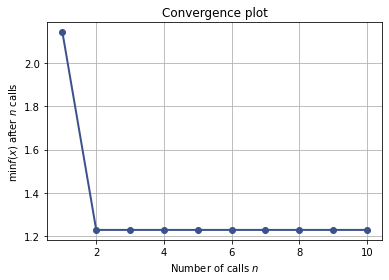

In [6]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [8]:
from skopt import dump, load

In [7]:
dump(res_gp, "1H_opt_RR")

In [9]:
my_res = load("1H_opt_RR")

In [10]:
my_res.x

[0.0015179251497629848,
 2.4553302346427,
 7.154759279489721,
 0.24518881446377816]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

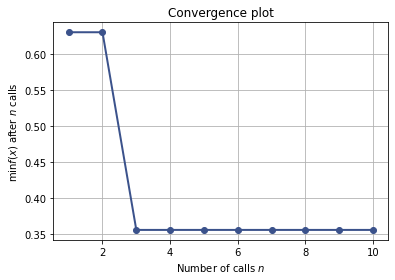

In [18]:
plot_convergence(my_res)